### Do age-related trends influence the observed AR(1) and Variance trends in the shell-growth record?

Annual growth increments of the shells of long-lived bivalves, such as *Arctica islandica*, are deposited synchronously amongst different individuals, evidencing that shell growth is driven by environmental factors (Butler *et al*., 2010). Thus, overlapping shell-growth measurements from different individuals allows the construction of long-term annually resolved records as proxies for the variability in the marine environment.Shell growth in bivalves is not only modulated by the environment but also by the stage of life. Shell increments are wider and highly variable when bivalves are younger, becoming narrower and less variable with age (Butler et al., 2010). Thus, the accurate construction of the chronologies relies on the removal of the age-related trend and variance stabilisation on individual shell measurements. The resulting standardised growth indices are then cross-dated between individual shell records to build the chronology. The construction process may also involve a step that removes individual lag-1 autocorrelation (Butler et al., 2010), keeping only common and synchronous autocorrelation (Cook and Holmes, 1986). Considering these techniques involve steps that modify variance and autocorrelation, they might affect the trends in early warning indicators for regime shifts. 

[Previous analyses](../ews_on_bivalve_proxies/Individual_shells_assessment.ipynb) demonstrate that after removing the ontogenetic trend by fitting a negative exponential function and stabilising variance through a data-adaptive method, the individual shell-growth records maintain a significant negative trend in variance and a slight negative trend in lag-1 autocorrelation.

**This notebook explores whether the age-related trends in variance and autocorrelation influence the observed trends in both metrics on the [shell-growth record from the North Icelandic Shelf (Butler et al., 2010)](https://www.ncei.noaa.gov/access/paleo-search/study/14609) before 1260.** First, we compute the resilience metrics on the individual records used to build the long-term chronology to observe their trends ca. 1260. Then, we assess the probability of obtaining the observed trends in variance and autocorrelation by the successive introduction of individual shell-growth records during that interval.

### Table of contents:
- [Two versions of the chronology: RCS and NE](#versions)
- [Persistence of the age-related trends in variance and autocorrelation](#persistence_age-related_trends)
    - [Separating the potential effect of the environment](#trends_periods_no_changes_res)
- [Trends in AR(1) and variance measured over each version](#trends_each_version)
- [Resilience metrics computed over the individual shell-growth records](#trends_ind_rec_1260)
- [Assessing the probability of obtaining the observed trends by the successive introduction of shell-growth records](#trends_ind_rec_1260)
- [Conclusions](#conclusions)
- [Appendix: The power-transformation method to stabilise variance](#cook_peters_method)
- [References](#references)



In [1]:
%matplotlib inline
from astropy import stats
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import skew, skewtest, kstest
from sklearn.linear_model import LinearRegression
import string
import sys
sys.path.append('../../lib/')
from regimeshifts import ews

In [2]:
## The files are available at https://www.ncei.noaa.gov/access/paleo-search/study/14609
data_path = '../../../datasets/bivalve-sclerochronologies/Butler_Iceland_2013/'
raw_meas = 'butler2013-raw.txt'  # Raw measurements
lifetimes = 'butler2013-lifetimes.txt' ## Life-span of each individual
chron = 'butler2013-chron.txt' ## chronologies

<a id='versions'></a>
## Two versions of the shell-growth chronology: NE and RCS
**NE**: The age-related trend is removed by fitting a negative exponential function to each shell series after stabilising variance with a data-adaptive power-transformation method.

**RCS**: Regional Curve Standardisation is a method that uses the average of the width measurements at each age as the expected growth value. Thus, it produces a statistical trend for all shells. This technique, developed to address the 'segment length curse' problem in dendrochronology, preseves better low frequency variability. 

In [3]:
chrons = pd.read_csv(data_path+chron, comment='#', sep='\t', index_col=0)
chrons.head(3)

,NE.ars,RCS.ars
age_AD,,
649,2.477,2.919
650,2.145,2.566
651,1.695,1.915


In [4]:
### Reading individual shell measurements
raw_growth = pd.read_csv(data_path+raw_meas, comment='#', sep='\t', header=[0,1], encoding="ISO-8859-1")
#### Assigning pairs of columns
shells_c = []
for i,c in enumerate(raw_growth.columns):
    if i%2 == 0:
        shells_c.append([c[0],''])            
    else:
        shells_c[i//2][1]=c[0]
shell_m = []
lifetime = {}
for c in shells_c:
    ts = pd.DataFrame(index=raw_growth[c][raw_growth[c[0]]['age_AD']>0][c[0]]['age_AD'].values,
              data = raw_growth[c][raw_growth[c[0]]['age_AD']>0][c[1]]['a.island-um'].values, columns=[c[1]])
    lifetime[c[1]] = [ts.index.min(),ts.index.max()]
    shell_m.append(ts)

raw_shells = pd.concat(shell_m, axis=1, sort=False) ## Dataframe containing individual shell measuremets
lifetime_sort = {k: v for k, v in sorted(lifetime.items(), key=lambda item: item[1])} # Sorted lifetimes
age = {k: v[1]-v[0] for k, v in lifetime_sort.items()} #Sorted individual ages

<a id='persistence_age-related_trends'></a>
## Age-related trends in variance and autocorrelation after detrending with the Negative exponential method

 We assess the indicators' trends over the individual shell records after removing the age-related trend by fitting a Negative exponential function and stabilising variance using the [Cook and Peters (1997) data-adaptive power transformation method](#cook_peters_method).
 
**Does the age-related trend in variance persist after stabilising variance?**

We use a 40-year window size to look into more detail at the trends during the first years. When looking at the distribution of Kendall $\tau$ coefficients, we can observe that the trends in variance are significantly biased towards negative values, indicating that the stabilisation method does not remove the ontogenetic trend completely. Autocorrelation also exhibits higher values during the earliest years resulting in a slight negative bias towards negative trends. The significantly negative bias in variance persists under a range of window lengths and is also observed on shells collected from a different region (see a [more detailed analysis](../ews_on_bivalve_proxies/Individual_shells_assessment.ipynb)). However, considering the scenario in which the environment is the primary driver of the observed signal, we would expect to measure biased ontogenetic trends on shells introduced around periods with marked changes in resilience. 

The histograms represent the distribution of Kendall $\tau$ values. The skewness (skew) is measured, and the p-value gives its significance. P-values less than 0.05 indicate a significant bias.

In [5]:
def negexp(t, a, b, k):
    """
    Defines a negative exponential function
    """
    return ((a * np.exp(-b * t)) + k)

def power_transf(ts):
    """
    Removes the age-related trend on a shell-growth series 
    by fitting a negative exponential function after 
    stabilising variance using the power transformation 
    method proposed by Cook and Peters (1997).
    Parameters
    --------
    ts: Pandas Series
    
    Returns
    --------
    pow_trans: Pandas Series
               The power-transformed series before removing 
               the age-related trend.
    fitted_curve_pt: Pandas Series
               The fitted negative exponential function.
    
    res_pt: Pandas Series
            The resulting residuals after stabilising variance
            and removing the fitted curve.                   
        
    
    """
    lm = ts.rolling(window=2).mean() ## 2-year moving average
    ls = ts.rolling(window=2).apply(lambda x: np.abs(x.iloc[1] - x.iloc[0])) ##Standard deviation
    for i in ls[ls==0].index: ## If std dev is zero we average the values around
        try:
            ls.at[i] = np.mean([ls.loc[i-1],ls.loc[i+1]])
        except:
            ls.at[i] = ls.loc[i-1]
    log_lm = np.log(lm) ## log of mean and std dev to linearise the relationship between both.
    log_ls = np.log(ls)
    ## Fitting a linear model to find the slope b (logS = k + blogM)
    linear_fit = LinearRegression().fit(log_lm.dropna().values.reshape((-1, 1)),log_ls.dropna().values.reshape((-1, 1)))
    slope = linear_fit.coef_[0][0]
    ### Applying the power transformation to stabilise variance (Rtr = Rms^(1-b))
    pow_trans = np.power(ts,1-slope)
    ### Fitting a negative exponential function to the power-transformed measurements
    index_val = np.arange(1,len(pow_trans.index.values)+1)
    popt_pt, pcov = curve_fit(negexp, index_val, pow_trans.values, maxfev=20000)
    fitted_curve_pt = negexp(index_val, *popt_pt)
    ### Subtracting the fitted negative exponential function from the original measurements
    res_pt = pow_trans - fitted_curve_pt
    return pow_trans, fitted_curve_pt, res_pt

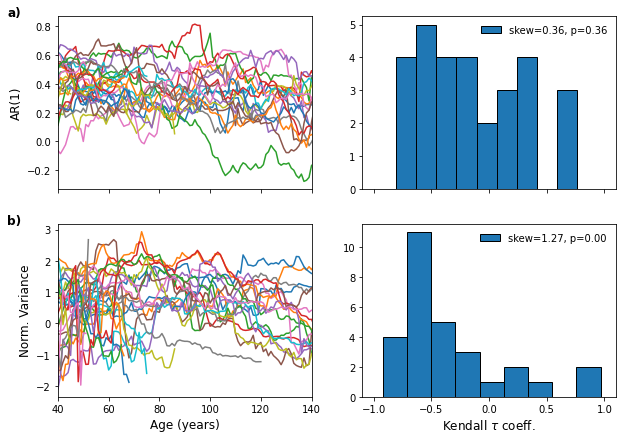

In [7]:
kc_ar1 = []
kc_var = []
wL = 40
bW = 40
fig,axs = plt.subplots(2,2,figsize=(10,7),sharex='col')
for i,(shell, lt) in enumerate(lifetime_sort.items()):
    ts = ews.Ews(raw_shells[shell].dropna())
    winL = wL if len(ts)>1.25*wL else int(len(ts)*0.75)
    if (len(ts) - winL) > 10:
        _,_,pt = power_transf(ts+100) ## Adds 100 to avoid zeros when log-transforming        
        ar1 = ews.Ews(pt).ar1(detrend=True,wL=winL,bW=bW)
        var = ews.Ews(pt).var(detrend=True,wL=winL,bW=bW)
        norm_var = (var-var.mean())/var.std()
        norm_var = (var-var.mean())/var.std()
        ar1 = ews.Ews(ar1.dropna().reset_index(drop=True))
        norm_var = ews.Ews(norm_var.dropna().reset_index(drop=True))
        ar1.index += winL
        norm_var.index += winL
        ar1.plot(ax=axs[0,0])
        norm_var.plot(ax=axs[1,0])
        kc_ar1.append(ar1.kendall)
        kc_var.append(var.kendall)
## Histograms
axs[0,1].hist(kc_ar1,bins=9,label=f'skew={skew(kc_ar1):.2f}, p={skewtest(kc_ar1).pvalue:.2f}',edgecolor = "black")  
axs[1,1].hist(kc_var,bins=9,label=f'skew={skew(kc_var):.2f}, p={skewtest(kc_var).pvalue:.2f}',edgecolor = "black")
for i in [0,1]:
    axs[i,0].set_xlim(wL,100+wL)
    axs[1,i].set_xlim(-1.1,1.1)
    axs[i,1].legend(frameon=False)
    axs[i,0].text(-0.2, 1, string.ascii_lowercase[i]+')', transform=axs[i,0].transAxes, size=12,weight='bold')
axs[1,0].set_xlabel('Age (years)',fontsize=12)
axs[1,1].set_xlabel(r'Kendall $\tau$ coeff.',fontsize=12)
axs[0,0].set_ylabel('AR(1)',fontsize=12)
axs[1,0].set_ylabel('Norm. Variance',fontsize=12);
#fig.savefig('img/age_related_trends.png',dpi=200, bbox_inches='tight', facecolor='white')

<a id='trends_periods_no_changes_res'></a>
### Measuring the ontogenetic trends over periods without apparent changes in resilience

The marine environment potentially lost resilience before 1260 and recovered afterwards, as isotope bivalve-derived records also suggest. That period coincides with the introduction of different individual shell-growth series. To separate the signal in the environment from the age-related trends, we compute the ontogenetic trends on shells introduced to the chronology after 1450. In this analysis, the distribution of Kendall 𝜏 coefficients seems more uniform for AR(1) although a slight not significant bias persists. For variance, the significant negative bias persists.

The persistence of the age-related trends might have an effect on AR(1) and variance trends when measured over the resulting cross-dated chronologies. For example, an interval with the successive introduction of new shell records might exhibit a marked increase in variance and a slight increase in autocorrelation.

In [8]:
recent_shells = {k:yr for k,yr in lifetime_sort.items() if yr[0]>=1450}

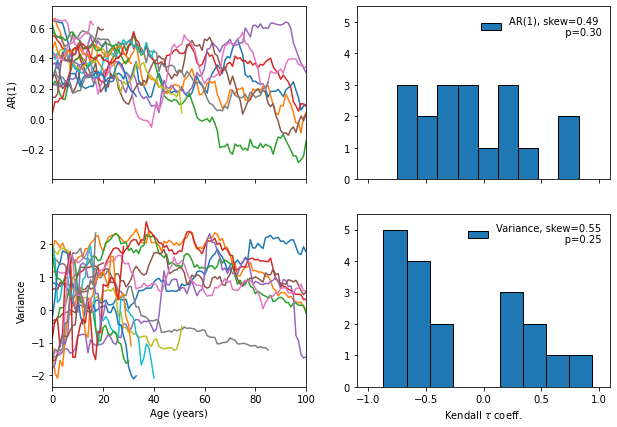

In [9]:
kc_ar1 = []
kc_var = []
wL = 35
fig,axs = plt.subplots(2,2,figsize=(10,7),sharex='col')
for i,(shell, lt) in enumerate(recent_shells.items()):
    ts = ews.Ews(raw_shells[shell].dropna())
    winL = wL if len(ts)>1.25*wL else int(len(ts)*0.75)
    if (len(ts) - winL) > 10:
        _,_, pt = power_transf(ts+100) ## Adds 100 to avoid zeros when log-transforming    
        ar1 = ews.Ews(pt).ar1(detrend=True,wL=winL,bW=bW)
        var = ews.Ews(pt).var(detrend=True,wL=winL,bW=bW)
        norm_var = (var-var.mean())/var.std()
        ar1.dropna().reset_index(drop=True).plot(ax=axs[0,0])
        norm_var.dropna().reset_index(drop=True).plot(ax=axs[1,0])
        kc_ar1.append(ar1.kendall)
        kc_var.append(var.kendall)
sk_ar1 = skew(kc_ar1)
sk_var = skew(kc_var)
## Histograms
axs[0,1].hist(kc_ar1,bins=9,label=f'AR(1), skew={sk_ar1:.2f}\n'+' '*18 +f'p={skewtest(kc_ar1).pvalue:.2f}',edgecolor = "black")  
axs[1,1].hist(kc_var,bins=9,label=f'Variance, skew={sk_var:.2f}\n'+' '*22 +f'p={skewtest(kc_var).pvalue:.2f}',edgecolor = "black")
for i in [0,1]:
    axs[i,0].set_xlim(0,100)
    axs[1,i].set_xlim(-1.1,1.1)
    axs[i,1].legend(frameon=False)
    axs[i,1].set_ylim(0,5.5)
axs[1,0].set_xlabel('Age (years)')
axs[1,1].set_xlabel(r'Kendall $\tau$ coeff.')
axs[0,0].set_ylabel('AR(1)')
axs[1,0].set_ylabel('Variance');

<a id='trends_each_version'></a>
## Resilience metrics on each version: NE and RCS

We compute the resilience indicators over each version (NE and RCS) to compare the trends between them. AR(1) and variance follow similar trends on both versions; particularly before 1260, both records exhibit significant increasing trends in AR(1) and variance over the shaded region in the figure. Considering that the age-related trends are not completely removed with the negative-exponential method, the results here indicate either that the RCS method performs similarly at removing the ontogenetic trend or that the persistent age-related trends do not affect the trends in the resilience indicators. However, we can observe that the interval between 1170 and 1260 coincides with the successive introduction of five shell records. The accumulative effect of high values in AR(1) and variance during the early years might result in positive trends in each indicator.

In [10]:
wL = 70 # window length
bW = 40 # Bandwidth
records = {}
records['NE'] = ews.Ews(chrons['NE.ars'][chrons.index>1000]) ## The NE chron after 1000 CE
records['RCS'] = ews.Ews(chrons['RCS.ars'][chrons.index>1000])## The RCS chron after 1000 CE

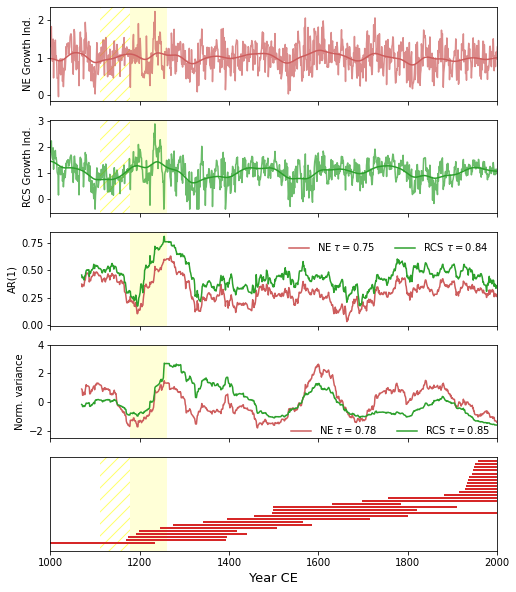

In [11]:
fig, axs = plt.subplots(5,1,figsize=(8,10),sharex=True)
colors = ['indianred','tab:green']
for i,(ch,ts) in enumerate(records.items()):    
    ts.plot(ax=axs[i],label=ch,color=colors[i],alpha=0.7)
    ts.gaussian_det(bW=bW).trend.plot(ax=axs[i],color=colors[i],label='')
    ar1 = ts.ar1(detrend=True,bW=bW,wL=wL)
    var = ts.var(detrend=True,bW=bW,wL=wL)
    norm_var = (var - var.mean())/var.std()
    kv_ar1 = ews.Ews(ar1[(ar1.index>=1179) & (ar1.index<=1260)]).kendall
    kv_var = ews.Ews(norm_var[(norm_var.index>=1179) & (norm_var.index<=1260)]).kendall
    ar1.plot(ax=axs[2],label=ch+rf' $\tau=${kv_ar1:.2f}',color=colors[i])    
    norm_var.plot(ax=axs[3],label=ch+rf' $\tau=${kv_var:.2f}',color=colors[i])
    axs[i].set_ylabel(f'{ch} Growth Ind.')
    
for i,(shell, lt) in enumerate(lifetime_sort.items()):
    axs[-1].plot((lt[0],lt[1]),(i,i),color='tab:red',linewidth=2)
axs[2].set_ylabel('AR(1)')
axs[3].set_ylabel('Norm. variance');
axs[-1].set_xlabel('Year CE',fontsize=13)
for i,ax in enumerate(axs):
    ax.axvspan(1179, 1260, color=(255/255,255/255,0,40/255), lw=0)  
    if i in [2,3]:
        ax.legend(frameon=False,ncol=2)
    else:
        ax.axvspan(1110,1179,hatch="//", facecolor="none",edgecolor=(255/255,255/255,0,150/255), lw=0)
axs[3].set_ylim(-2.5,4)
axs[3].legend(frameon=False,ncol=2,loc=(0.53,-0.02))
axs[-1].set_xlim(1000,2000)
axs[-1].set_yticks([]);
#fig.savefig('gi_rcs_ne.png',dpi=200)

<a id='trends_ind_rec_1260'></a>
## AR(1) and variance trends on individual shell-growth records circa 1260

To determine whether the successive introduction of shell records results in positive trends in AR(1) and variance, we compute both metrics over the individual shell records ca. 1260. When looking at the trends in AR(1) and variance, it is evident that the individual shells share a common trend and similar values for both metrics between 1200 and 1260, regardless of their age. Using a small (35-40 years) sliding window allows measuring the trend over the shell series found at that time: a larger window would leave only a small interval to measure over the youngest bivalves, and a smaller one would not be suitable to observe the trend. Notably, the four bivalves that lived around 1260 exhibit lower values for AR(1) and variance during the earliest years, reaching the highest values circa 1260. If the age-related trend dominated the signal, we would expect to observe the highest values at the beginning, particularly for variance (unless the ontogenetic trend involves an increase in variance during part of the mature years?). Furthermore, the same increasing trend is observed during the last years of the oldest individual. This result suggests that the observed trend likely reflects changes in the environment. However, just by looking at the trends, it is not possible to differentiate the signal in the environment from that produced by the age-related trends. 

In [12]:
mca_shells = {shell: ls for shell, ls in lifetime_sort.items() if ls[0] < 1210 and ls[0] > 900}

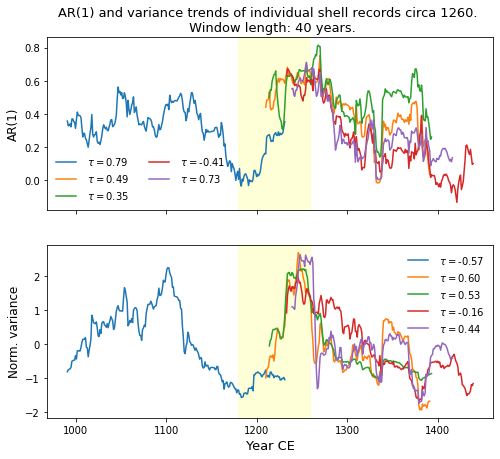

In [13]:
wL = 40
bW = 40
fig, axs = plt.subplots(2,1,figsize=(8,7),sharex=True)
for shell, ls in mca_shells.items():
    ts = ews.Ews(raw_shells[shell].dropna())
    _,_, pt = power_transf(ts+100)
    ar1 = ews.Ews(pt).ar1(detrend=True,wL=wL,bW=bW)
    var = ews.Ews(pt).var(detrend=False,wL=wL)
    norm_var = (var-var.mean())/var.std()
    kv_ar1 = ews.Ews(ar1[(ar1.index>=1200)&(ar1.index<=1260)]).kendall
    kv_var = ews.Ews(norm_var[(norm_var.index>=1200)&(norm_var.index<=1260)]).kendall
    ar1.plot(ax=axs[0],label=rf' $\tau=${kv_ar1:.2f}')
    norm_var.plot(ax=axs[1],label=rf' $\tau=${kv_var:.2f}')
axs[0].set_ylabel('AR(1)',fontsize=12);
axs[1].set_ylabel('Norm. variance',fontsize=12);
axs[0].set_title(f'AR(1) and variance trends of individual shell records circa 1260. \n Window length: {wL} years.',\
             fontsize=13);
for i in [0,1]:
    axs[i].axvspan(1179, 1260, color=(255/255,255/255,0,40/255), lw=0)
    axs[i].legend(frameon=False,ncol=2 if i==0 else 1)
axs[-1].set_xlabel('Year CE',fontsize=13);
#fig.savefig('ind_shells_trends.png',dpi=200)

#### AR(1) and variance trends on individual shell-growth records after removing the first 30 years

In [14]:
def remove_first_values(shells_df, n):
    """
    Removes the first n values from each shell record
    """
    shorter_shells = shells_df.copy(deep=True)
    for col in shorter_shells.columns:
        indices = shorter_shells[col].dropna().iloc[0:n].index.values
        shorter_shells[col].loc[indices] = np.nan
    return shorter_shells

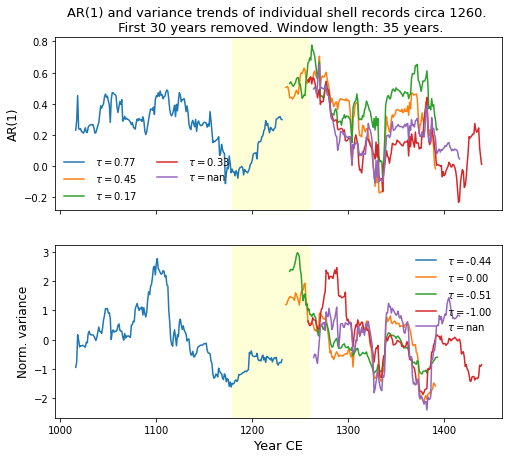

In [15]:
wL = 35
bW = 30
fig, axs = plt.subplots(2,1,figsize=(8,7),sharex=True)
mca_shells_rm30 = remove_first_values(raw_shells[mca_shells.keys()],30)
for shell, ls in mca_shells_rm30.items():
    ts = ews.Ews(mca_shells_rm30[shell].dropna())
    _,_, pt = power_transf(ts+100)
    ar1 = ews.Ews(pt).ar1(detrend=True,wL=wL,bW=bW)
    var = ews.Ews(pt).var(detrend=False,wL=wL)
    norm_var = (var-var.mean())/var.std()
    kv_ar1 = ews.Ews(ar1[(ar1.index>=1200)&(ar1.index<=1260)]).kendall
    kv_var = ews.Ews(norm_var[(norm_var.index>=1200)&(norm_var.index<=1260)]).kendall
    ar1.plot(ax=axs[0],label=rf' $\tau=${kv_ar1:.2f}')
    norm_var.plot(ax=axs[1],label=rf' $\tau=${kv_var:.2f}')
axs[0].set_ylabel('AR(1)',fontsize=12);
axs[1].set_ylabel('Norm. variance',fontsize=12);
axs[0].set_title(f'AR(1) and variance trends of individual shell records circa 1260. \n First 30 years removed. Window length: {wL} years.',\
             fontsize=13);
for i in [0,1]:
    axs[i].axvspan(1179, 1260, color=(255/255,255/255,0,40/255), lw=0)
    axs[i].legend(frameon=False,ncol=2 if i==0 else 1)
axs[-1].set_xlabel('Year CE',fontsize=13);
#fig.savefig('ind_shells_trends.png',dpi=200)

<a id='probability'></a>
## Assessing the probability of obtaining the observed trends by successively introducing random shell records

In addition to the age-related effects, the variance trends can also be affected by the variable number of replicates through time, expecting to observe increased variance over regions with the smallest sample size. To assess the probability of obtaining the observed signal due to both effects, we compare the observed trends to those obtained from three null models. Each null model comprises 1,000 surrogate series, and each series was created by introducing randomly chosen individual shell records following the original chronology between 1100 and 1260.  The probability of obtaining the observed trend under each scenario is measured as the proportion of surrogate series that yield higher or equal Kendall τ values as those obtained from a series built in the same way but preserving the original order in the shell records. 

The results from the null models indicate that it is highly unlikely that the observed trend during the first episode resulted from age-related effects or due to the variable number of replicates. Furthermore, the synchronicity in the trends with the isotope-derived records around that period discards the possibility that age-related effects purely generate the trends in the shell-growth record. These results give us confidence that changes in the environment primarily drive the observed trend before 1260.

#### First null model: assessing the age-related effects

In this model, the indicators are computed over the individual records and annually-averaged to obtain each surrogate series. After building the ensemble of surrogate series, we find that, as expected, they exhibit mostly positive trends between 1200 and 1260 for both metrics. This bias can be attributed to the age-related effect, confirming that the successive introduction of shells can lead to positive trends in both indicators. However, the proportion of series that yield larger values than the measured in the original records is less than 0.02 for both metrics.

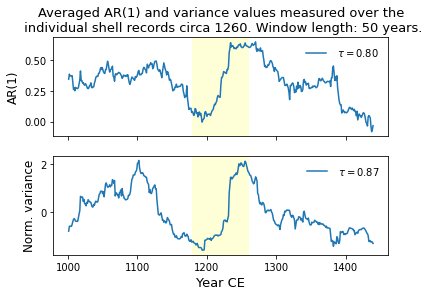

In [357]:
wL = 50
bW = 40
ar1_ts = []
var_ts = []
fig, axs = plt.subplots(2,1,figsize=(6,4),sharex=True)
for shell, ls in mca_shells.items():
    ts = ews.Ews(raw_shells[shell].dropna())
    _,_, pt = power_transf(ts+100)
    ar1 = ews.Ews(pt).ar1(detrend=True,wL=wL,bW=bW)
    var = ews.Ews(pt).var(detrend=False,wL=wL)
    norm_var = (var-var.mean())/var.std()
    ar1_ts.append(ar1)
    var_ts.append(norm_var)
ar1_mca = pd.concat(ar1_ts, axis=1, sort=False)
var_mca = pd.concat(var_ts, axis=1, sort=False)
avg_ar1 = ar1_mca.mean(axis=1).dropna()
avg_var = var_mca.mean(axis=1).dropna()
kv_ar1 = ews.Ews(avg_ar1[(avg_ar1.index>=1200)&(avg_ar1.index<=1260)]).kendall
kv_var = ews.Ews(avg_var[(avg_var.index>=1200)&(avg_var.index<=1260)]).kendall
avg_ar1.plot(ax=axs[0],label=rf' $\tau=${kv_ar1:.2f}')
avg_var.plot(ax=axs[1],label=rf' $\tau=${kv_var:.2f}')
axs[0].set_ylabel('AR(1)',fontsize=12);
axs[1].set_ylabel('Norm. variance',fontsize=12);
axs[0].set_title(f'Averaged AR(1) and variance values measured over the\n individual shell records circa 1260. Window length: {wL} years.',\
             fontsize=13);
for i in [0,1]:
    axs[i].axvspan(1179, 1260, color=(255/255,255/255,0,40/255), lw=0)
    axs[i].legend(frameon=False,ncol=2 if i==0 else 1)
axs[-1].set_xlabel('Year CE',fontsize=13);
#fig.savefig('img/avg_trends_right_order.png',dpi=200, bbox_inches='tight')

##### Null model 1: Building a surrogate series
Each surrogate series is obtained by introducing random shell records at the same time as in the original chronology. AR(1) and variance are computed for each record, and then the values are annually-averaged between individual records. The trend in each metric is measured between 1200 and 1260.

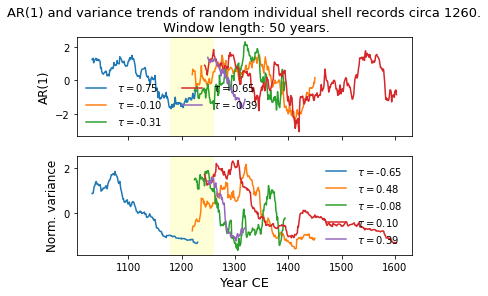

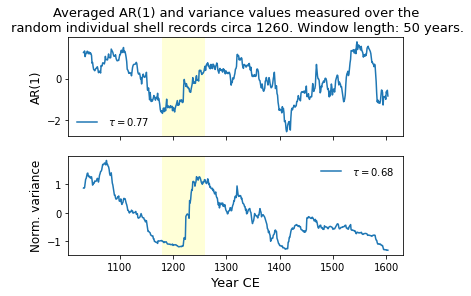

In [359]:
wL = 50
bW = 40
ar1_ts_rdn = []
var_ts_rdn = []
fig, axs = plt.subplots(2,1,figsize=(6,4),sharex=True)
rdm_shells = []
for shell,ls in mca_shells.items():
    min_age = 1260-ls[0]+10 if ls[0]>1110 else 100
    older_shells = [sh for sh,ag in age.items() if ag >= min_age and sh!=shell and sh not in rdm_shells]
    random_shell = np.random.choice(older_shells, size=1)[0]
    rdm_shells.append(random_shell)
    ts = raw_shells[random_shell].dropna()
    if ls[0]<1110:
        ts.index = np.arange(ls[1]-len(ts),ls[1])
    else:
        ts.index = np.arange(ls[0],ls[0]+len(ts))
    _,_, pt = power_transf(ts+100)
    ar1 = ews.Ews(pt).ar1(detrend=True,wL=wL,bW=bW)
    var = ews.Ews(pt).var(detrend=False,wL=wL)
    ### AR(1) and Variance values are standardised
    std_ar1 = (ar1-ar1.mean())/ar1.std()
    norm_var = (var-var.mean())/var.std()
    ar1_ts_rdn.append(std_ar1)
    var_ts_rdn.append(norm_var)
    kv_ar1 = ews.Ews(std_ar1[(std_ar1.index>=1200)&(std_ar1.index<=1260)]).kendall
    kv_var = ews.Ews(norm_var[(norm_var.index>=1200)&(norm_var.index<=1260)]).kendall
    std_ar1.plot(ax=axs[0],label=rf' $\tau=${kv_ar1:.2f}')
    norm_var.plot(ax=axs[1],label=rf' $\tau=${kv_var:.2f}')
axs[0].set_ylabel('AR(1)',fontsize=12);
axs[1].set_ylabel('Norm. variance',fontsize=12);
axs[0].set_title(f'AR(1) and variance trends of random individual shell records circa 1260.\n Window length: {wL} years.',\
             fontsize=13);
for i in [0,1]:
    axs[i].axvspan(1179, 1260, color=(255/255,255/255,0,40/255), lw=0)
    axs[i].legend(frameon=False,ncol=2 if i==0 else 1)
axs[-1].set_xlabel('Year CE',fontsize=13);
plt.show()
##Averaged values
fig, axs = plt.subplots(2,1,figsize=(6,4),sharex=True)
ar1_mca_rdn = pd.concat(ar1_ts_rdn, axis=1, sort=False)
var_mca_rdn = pd.concat(var_ts_rdn, axis=1, sort=False)
avg_ar1_rdn = ar1_mca_rdn.mean(axis=1).dropna()
avg_var_rdn = var_mca_rdn.mean(axis=1).dropna()
kv_ar1 = ews.Ews(avg_ar1_rdn[(avg_ar1_rdn.index>=1200)&(avg_ar1_rdn.index<=1260)]).kendall
kv_var = ews.Ews(avg_var_rdn[(avg_var_rdn.index>=1200)&(avg_var_rdn.index<=1260)]).kendall
avg_ar1_rdn.plot(ax=axs[0],label=rf' $\tau=${kv_ar1:.2f}')
avg_var_rdn.plot(ax=axs[1],label=rf' $\tau=${kv_var:.2f}')
axs[0].set_ylabel('AR(1)',fontsize=12);
axs[1].set_ylabel('Norm. variance',fontsize=12);
axs[0].set_title(f'Averaged AR(1) and variance values measured over the\n random individual shell records circa 1260. Window length: {wL} years.',\
             fontsize=13);
for i in [0,1]:
    axs[i].axvspan(1179, 1260, color=(255/255,255/255,0,40/255), lw=0)
    axs[i].legend(frameon=False,ncol=2 if i==0 else 1)
axs[-1].set_xlabel('Year CE',fontsize=13);

#### Building the first null model with 1,000 surrogate series

We measure the strength of the trend in AR(1) and variance with the Kendall $\tau$ coefficient over the interval between 1200 and 1260. Then, we measure the proportion of $\tau$ values larger or equal to the observed in the original series. This proportion represents the probability of obtaining the observed trend due to age-related effects.
In the figure, the vertical line represents the measured Kendall value on the series obtained with the same shell-records as in the original chronology.

In [18]:
n = 1000 ## Size of the null model
wL = 50
bW = 40
kv_avg_ar1_rdn = []
kv_avg_var_rdn = []
for i in np.arange(0,n):
    ar1_ts_rdn = []
    var_ts_rdn = []
    rdm_shells = []
    for shell,ls in mca_shells.items():
        min_age = 1260-ls[0]+10 if ls[0]>1110 else 100
        older_shells = [sh for sh,ag in age.items() if ag >= min_age and sh!=shell and sh not in rdm_shells]
        random_shell = np.random.choice(older_shells, size=1)[0]
        rdm_shells.append(random_shell)
        ts = raw_shells[random_shell].dropna()
        if ls[0]<1110:
            ts.index = np.arange(ls[1]-len(ts),ls[1])
        else:
            ts.index = np.arange(ls[0],ls[0]+len(ts))
        _,_, pt = power_transf(ts+100)
        ar1 = ews.Ews(pt).ar1(detrend=True,wL=wL,bW=bW)
        var = ews.Ews(pt).var(detrend=False,wL=wL)
        ## Standardisation of AR(1) and variance
        std_ar1 = (ar1-ar1.mean())/ar1.std()
        norm_var = (var-var.mean())/var.std()
        ar1_ts_rdn.append(std_ar1)
        var_ts_rdn.append(norm_var)
    ar1_mca_rdn = pd.concat(ar1_ts_rdn, axis=1, sort=False)
    var_mca_rdn = pd.concat(var_ts_rdn, axis=1, sort=False)
    avg_ar1_rdn = ar1_mca_rdn.mean(axis=1).dropna()
    avg_var_rdn = var_mca_rdn.mean(axis=1).dropna()
    kv_ar1 = ews.Ews(avg_ar1_rdn[(avg_ar1_rdn.index>=1200)&(avg_ar1_rdn.index<=1260)]).kendall
    kv_var = ews.Ews(avg_var_rdn[(avg_var_rdn.index>=1200)&(avg_var_rdn.index<=1260)]).kendall
    kv_avg_ar1_rdn.append(kv_ar1)
    kv_avg_var_rdn.append(kv_var)

In [19]:
kv_avg_ar1_orig = ews.Ews(avg_ar1[(avg_ar1.index>=1200)&(avg_ar1.index<=1260)]).kendall
kv_avg_var_orig = ews.Ews(avg_var[(avg_var.index>=1200)&(avg_var.index<=1260)]).kendall
p_avg_ar1 = len([kv for kv in kv_avg_ar1_rdn if kv>=kv_avg_ar1_orig])/len(kv_avg_ar1_rdn)
p_avg_var = len([kv for kv in kv_avg_var_rdn if kv>=kv_avg_var_orig])/len(kv_avg_var_rdn)

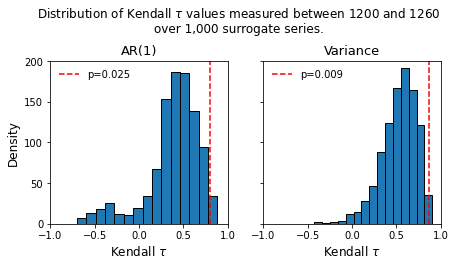

In [20]:
title = ['AR(1)', 'Variance']
fig, axs = plt.subplots(1,2,figsize=(7,3),sharey=True)
axs[0].hist(kv_avg_ar1_rdn,bins=15,edgecolor='k')
axs[1].hist(kv_avg_var_rdn,bins=15,edgecolor='k')
axs[0].axvline(kv_avg_ar1_orig,color='r',linestyle='dashed', linewidth=1.5,label=f'p={p_avg_ar1:.3f}')
axs[1].axvline(kv_avg_var_orig,color='r',linestyle='dashed', linewidth=1.5,label=f'p={p_avg_var:.3f}')
for j in [0,1]:
    axs[j].set_xlim(-1,1)
    axs[j].legend(frameon=False)
    axs[j].set_xlabel(r'Kendall $\tau$',fontsize=12)
    axs[j].set_title(f'{title[j]}',fontsize=13)
axs[0].set_ylabel('Density',fontsize=12);
fig.suptitle(r'Distribution of Kendall $\tau$ values measured between 1200 and 1260' +'\nover 1,000 surrogate series.',y=1.13);
#fig.savefig('img/model_shell_growth.png',dpi=200, bbox_inches='tight')

#### Null model 2: Testing the effect of a variable number of replicates through time

In this case, each surrogate series is generated by averaging synthetic white-noise series of the same length, mean and variance as the shell records from the original chronology. This experiment demonstrates that the variable number of replicates significantly affects the variance trends, resulting in negative trends because the number of replicates starts with one and increases progressively to six before 1260.

In [333]:
### Building an ensemble model with synthetic white-noise shells to assess the effect of a variable number of replicates through time
n = 1000 ## Size of the null model
wL = 50
bW = 40
kv_ar1_synth = []
kv_var_synth = []
for i in np.arange(0,n):
    ind_synth_ts = []
    for shell,ls in mca_shells.items():        
        orig_ts = raw_shells[shell].dropna()
        _,_, pt = power_transf(orig_ts+100)
        ts_std = (pt - pt.mean())/pt.std()
        white_noise = np.random.normal(ts_std.mean(),ts_std.std(),len(ts_std))
        synth_shell = pd.Series(index=orig_ts.index,data=white_noise)
        ind_synth_ts.append(synth_shell)
    chron_synth = pd.concat(ind_synth_ts, axis=1, sort=False)
    avg_chron_synth = chron_synth.apply(stats.biweight_location, axis = 1,c=9,ignore_nan=True)
    ar1_synth = ews.Ews(avg_chron_synth).ar1(detrend=True,wL=wL,bW=bW)
    var_synth = ews.Ews(avg_chron_synth).var(detrend=False,wL=wL)
    kv_ar1_s = ews.Ews(ar1_synth[(ar1_synth.index>=1200)&(ar1_synth.index<=1260)]).kendall
    kv_var_s = ews.Ews(var_synth[(var_synth.index>=1200)&(var_synth.index<=1260)]).kendall
    kv_ar1_synth.append(kv_ar1_s)
    kv_var_synth.append(kv_var_s)

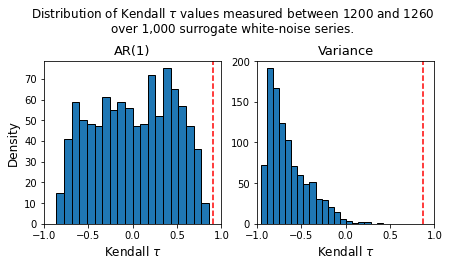

In [334]:
title = ['AR(1)', 'Variance']
fig, axs = plt.subplots(1,2,figsize=(7,3))
axs[0].hist(kv_ar1_synth,bins=20,edgecolor='k')
axs[1].hist(kv_var_synth,bins=20,edgecolor='k')
axs[0].axvline(kv_ar1_orig,color='r',linestyle='dashed', linewidth=1.5)
axs[1].axvline(kv_var_orig,color='r',linestyle='dashed', linewidth=1.5)
for j in [0,1]:
    axs[j].set_xlim(-1,1)
    axs[j].set_xlabel(r'Kendall $\tau$',fontsize=12)
    axs[j].set_title(f'{title[j]}',fontsize=13)
axs[0].set_ylabel('Density',fontsize=12);
#axs[0].set_ylim(0,80)
fig.suptitle(r'Distribution of Kendall $\tau$ values measured between 1200 and 1260' +'\nover 1,000 surrogate white-noise series.',y=1.13);
#fig.savefig('img/model_shell_growth2.png',dpi=200, bbox_inches='tight')

#### Third null model: Assessing the combined effects of a variable number of replicates and ontogenetic trends

In this experiment, each surrogate series is built by introducing random standardised individual shell records. The individual series are then combined by applying a biweight robust mean (as recommended to build these records). Finally, AR(1) and variance are computed over the resulting series. 
With this approach, variance is higher over the intervals in which the number of replicates is low. This results in a negative trend in variance because there is only one individual series before 1180, potentially masking any trend after that date and outweighing the age-related effects. In this experiment, the trends in AR(1) do not exhibit a bias towards positive values suggesting that autocorrelation is destroyed by averaging the series unless the individual records contain the same signal. The proportion of surrogate series that yield higher values than the observed in the original record is less than 0.002 for each metric.

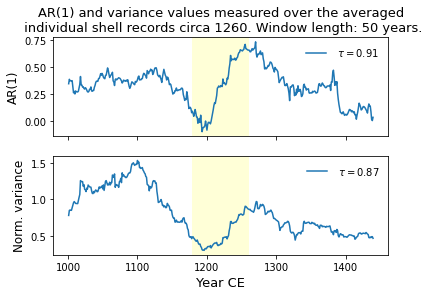

In [360]:
wL = 50
bW = 40
ind_ts = []
for shell, ls in mca_shells.items():
    ts = raw_shells[shell].dropna()
    _,_, pt = power_transf(ts+100)
    ts_std = (pt - pt.mean())/pt.std()
    ind_ts.append(ts_std)
chron = pd.concat(ind_ts, axis=1, sort=False)
## Obtaining the biweight robust mean as suggested by Cook et al (1990) with c=9
avg_chron = chron.apply(stats.biweight_location, axis = 1,c=9,ignore_nan=True)
ar1_avg = ews.Ews(avg_chron).ar1(detrend=True,wL=wL,bW=bW)
var_avg = ews.Ews(avg_chron).var(detrend=True,wL=wL,bW=bW)
kv_ar1 = ews.Ews(ar1_avg[(ar1_avg.index>=1200)&(ar1_avg.index<=1260)]).kendall
kv_var = ews.Ews(var_avg[(var_avg.index>=1200)&(var_avg.index<=1260)]).kendall
### Plots
fig, axs = plt.subplots(2,1,figsize=(6,4),sharex=True)
ar1_avg.plot(ax=axs[0],label=rf' $\tau=${kv_ar1:.2f}')
var_avg.plot(ax=axs[1],label=rf' $\tau=${kv_var:.2f}')
axs[0].set_ylabel('AR(1)',fontsize=12);
axs[1].set_ylabel('Norm. variance',fontsize=12);
axs[0].set_title(f'AR(1) and variance values measured over the averaged\n individual shell records circa 1260. Window length: {wL} years.',\
             fontsize=13);
for i in [0,1]:
    axs[i].axvspan(1179, 1260, color=(255/255,255/255,0,40/255), lw=0)
    axs[i].legend(frameon=False,ncol=2 if i==0 else 1)
axs[-1].set_xlabel('Year CE',fontsize=13);

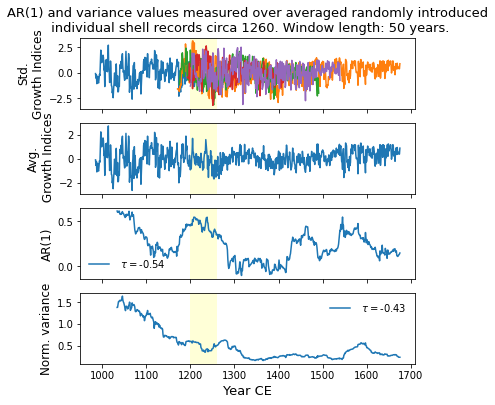

In [363]:
### Sample surrogate series following this method
wL = 50
bW = 40
rdm_shells = []
ind_ts = []
for shell,ls in mca_shells.items():
    min_age = 1260-ls[0]+10 if ls[0]>1110 else 100
    older_shells = [sh for sh,ag in age.items() if ag >= min_age and sh!=shell and sh not in rdm_shells]
    random_shell = np.random.choice(older_shells, size=1)[0]
    rdm_shells.append(random_shell)
    ts = raw_shells[random_shell].dropna()
    if ls[0]<1110:
        ts.index = np.arange(ls[1]-len(ts),ls[1])
    else:
        ts.index = np.arange(ls[0],ls[0]+len(ts))
    _,_, pt = power_transf(ts+100)
    ts_std = (pt - pt.mean())/pt.std()
    ind_ts.append(ts_std)
chron_rdm = pd.concat(ind_ts, axis=1, sort=False)
avg_chron_rdm = chron_rdm.apply(stats.biweight_location, axis = 1,c=9,ignore_nan=True)
ar1_rdm = ews.Ews(avg_chron_rdm).ar1(detrend=True,wL=wL,bW=bW)
var_rdm = ews.Ews(avg_chron_rdm).var(detrend=False,wL=wL)
kv_ar1_rdm = ews.Ews(ar1_rdm[(ar1_rdm.index>=1200)&(ar1_rdm.index<=1260)]).kendall
kv_var_rdm = ews.Ews(var_rdm[(var_rdm.index>=1200)&(var_rdm.index<=1260)]).kendall
### Plots
fig, axs = plt.subplots(4,1,figsize=(6,6),sharex=True)
chron_rdm.plot(ax=axs[0],legend=False)
avg_chron_rdm.plot(ax=axs[1],legend=False)
ar1_rdm.plot(ax=axs[2],label=rf' $\tau=${kv_ar1_rdm:.2f}')
var_rdm.plot(ax=axs[3],label=rf' $\tau=${kv_var_rdm:.2f}')
y_labels = ['Std.\nGrowth Indices','Avg.\n Growth Indices','AR(1)','Norm. variance']
axs[0].set_title(f'AR(1) and variance values measured over averaged randomly introduced\n individual shell records circa 1260. Window length: {wL} years.',\
             fontsize=13);
for i in [0,1,2,3]:
    axs[i].set_ylabel(f'{y_labels[i]}',fontsize=12);
    axs[i].axvspan(1200, 1260, color=(255/255,255/255,0,40/255), lw=0)
    if i in [2,3]:
        axs[i].legend(frameon=False)
axs[-1].set_xlabel('Year CE',fontsize=13);
#fig.savefig('img/rdn_recs.png',dpi=200, bbox_inches='tight')

In [349]:
n = 1000 ## Size of the null model
wL = 50
bW = 40
kv_ar1_rdn = []
kv_var_rdn = []
for i in np.arange(0,n):
    rdm_shells = []
    ind_rdm_ts = []
    for shell,ls in mca_shells.items():
        min_age = 1260-ls[0]+10 if ls[0]>1110 else 100
        older_shells = [sh for sh,ag in age.items() if ag >= min_age and sh!=shell and sh not in rdm_shells]
        random_shell = np.random.choice(older_shells, size=1)[0]
        rdm_shells.append(random_shell)
        ts = raw_shells[random_shell].dropna()
        if ls[0]<1110:
            ts.index = np.arange(ls[1]-len(ts),ls[1])
        else:
            ts.index = np.arange(ls[0],ls[0]+len(ts))
        _,_, pt = power_transf(ts+100)
        ts_std = (pt - pt.mean())/pt.std()
        ind_rdm_ts.append(ts_std)
    chron_rdm = pd.concat(ind_rdm_ts, axis=1, sort=False)
    avg_chron_rdm = chron_rdm.apply(stats.biweight_location, axis = 1,c=9,ignore_nan=True)
    ar1_rdm = ews.Ews(avg_chron_rdm).ar1(detrend=True,wL=wL,bW=bW)
    var_rdm = ews.Ews(avg_chron_rdm).var(detrend=False,wL=wL)
    kv_ar1_rdm = ews.Ews(ar1_rdm[(ar1_rdm.index>=1200)&(ar1_rdm.index<=1260)]).kendall
    kv_var_rdm = ews.Ews(var_rdm[(var_rdm.index>=1200)&(var_rdm.index<=1260)]).kendall
    kv_ar1_rdn.append(kv_ar1_rdm)
    kv_var_rdn.append(kv_var_rdm)

In [350]:
kv_ar1_orig = ews.Ews(ar1_avg[(ar1_avg.index>=1200)&(ar1_avg.index<=1260)]).kendall
kv_var_orig = ews.Ews(var_avg[(var_avg.index>=1200)&(var_avg.index<=1260)]).kendall
p_ar1 = len([kv for kv in kv_ar1_rdn if kv>=kv_ar1_orig])/len(kv_ar1_rdn)
p_var = len([kv for kv in kv_var_rdn if kv>=kv_var_orig])/len(kv_var_rdn)

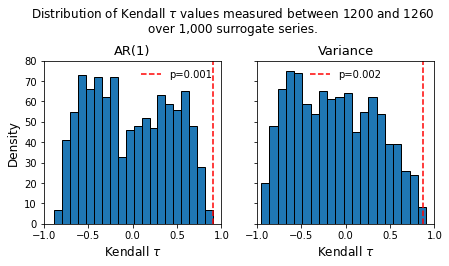

In [351]:
title = ['AR(1)', 'Variance']
fig, axs = plt.subplots(1,2,figsize=(7,3),sharey=True)
axs[0].hist(kv_ar1_rdn,bins=20,edgecolor='k')
axs[1].hist(kv_var_rdn,bins=20,edgecolor='k')
axs[0].axvline(kv_ar1_orig,color='r',linestyle='dashed', linewidth=1.5,label=f'p={p_ar1:.3f}')
axs[1].axvline(kv_var_orig,color='r',linestyle='dashed', linewidth=1.5,label=f'p={p_var:.3f}')
for j in [0,1]:
    axs[j].set_xlim(-1,1)
    axs[j].legend(frameon=False)
    axs[j].set_xlabel(r'Kendall $\tau$',fontsize=12)
    axs[j].set_title(f'{title[j]}',fontsize=13)
axs[0].set_ylabel('Density',fontsize=12);
axs[0].set_ylim(0,80)
fig.suptitle(r'Distribution of Kendall $\tau$ values measured between 1200 and 1260' +'\nover 1,000 surrogate series.',y=1.13);

In [364]:
### Kolmogorov-Smirnov test comparing the distributions of AR(1) trends between the second and third null models
kstest(kv_ar1_rdn,kv_ar1_synth)

KstestResult(statistic=0.07, pvalue=0.014870029418858987)

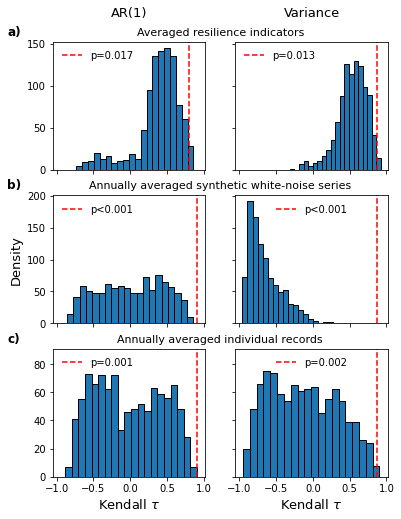

In [365]:
p_symbol = lambda p: '<' if p==0 else '='
p_val = lambda p: 0.001 if p==0 else p
fig, axs = plt.subplots(3,2,figsize=(6,8),sharex=True,sharey='row')
null_models = {'Avg_metrics': [kv_avg_ar1_rdn,kv_avg_var_rdn,kv_avg_ar1_orig,kv_avg_var_orig],
               'Synth_ts': [kv_ar1_synth,kv_var_synth,kv_ar1_orig,kv_var_orig],
               'Avg_chron': [kv_ar1_rdn,kv_var_rdn,kv_ar1_orig,kv_var_orig]}
titles = {'Avg_metrics': 'Averaged resilience indicators',
          'Avg_chron': 'Annually averaged individual records',
          'Synth_ts': 'Annually averaged synthetic white-noise series'}
for i,(k,distr) in enumerate(null_models.items()):
    axs[i,0].hist(distr[0],bins=20,edgecolor='k')
    axs[i,1].hist(distr[1],bins=20,edgecolor='k')
    p_ar1 = len([kv for kv in distr[0] if kv>=distr[2]])/len(distr[0]) 
    p_var = len([kv for kv in distr[1] if kv>=distr[3]])/len(distr[1])
    axs[i,0].text(1.1,1.05,titles[k],transform=axs[i,0].transAxes, size=11,ha='center')
    axs[i,0].text(-0.3, 1.05, string.ascii_lowercase[i]+')', transform=axs[i,0].transAxes, size=12,weight='bold')    
    if not np.isnan(distr[2]):
        axs[i,0].axvline(distr[2],color='r',linestyle='dashed', linewidth=1.5,label=f'p{p_symbol(p_ar1)}{p_val(p_ar1):.3f}')
        axs[i,1].axvline(distr[3],color='r',linestyle='dashed', linewidth=1.5,label=f'p{p_symbol(p_var)}{p_val(p_var):.3f}')
        axs[i,0].legend(frameon=False,loc=2)
        axs[i,1].legend(frameon=False)        
axs[2,0].set_ylim(0,axs[2,0].get_ylim()[1]+12);
axs[0,0].set_title('AR(1)',fontsize=13,y=1.15);
axs[0,1].set_title('Variance',fontsize=13,y=1.15);
[axs[-1,j].set_xlabel(r'Kendall $\tau$',fontsize=13) for j in [0,1]];
axs[1,0].set_ylabel('Density',fontsize=13);
#fig.savefig('img/null_models_rdm_ts.png',dpi=200, bbox_inches='tight', facecolor='white')

<a id='conclusions'></a>
## Conclusions

- An age-related trend in variance persists after stabilising variance and removing the ontogenetic trend by fitting a negative exponential function.
- Individual shell measurements exhibit higher AR(1) values during the first years, resulting in slightly negative although not significant trends. It is not clear whether this negative trend in AR(1) is due to physiological processes or is produced by the statistical techniques used in constructing the records.
- Both versions, RCS and NE, have similar trends in AR(1) and variance, particularly before 1260.
- The resilience indicators measured over the individual shell records circa 1260 share a common trend and similar values for both metrics regardless of their age, suggesting that the ontogenetic trends do not drive the observed signal. 
- Building surrogate series by successively introducing random shell records confirms that it is possible to obtain positive trends in AR(1) and variance purely associated with age-related effects. However, the effect of the variable number of replicates may outweigh the age-related effects. When the individual records are averaged, AR(1) is not affected by the ontogenetic trends.   
- The results from the null models indicate that it is highly unlikely that the observed signal before 1260 resulted from age-related effects or due to the variable number of replicates, supporting the idea that the environment is the primary driver of the observed signal before 1260.

<a id='cook_peters_method'></a>
### Appendix: Cook and Peters (1997) data-adaptive power transformation method to stabilise variance

The traditional method to stabilise variance involves obtaining ratios between measurements and the modelled growth: <br>
$GI_t = \frac{R_t}{M_t}$, &nbsp;&nbsp; where $R_t$ is the raw measurement at time $t$, and $M_t$ is the modelled growth value at time $t$. <br>
However, a negative exponential curve can be inflexible when fitting some intervals; thus, variance stabilisation through ratios can lead to enhanced variability in those poorly fitted regions (Butler *et al.*, 2010). A different approach proposed by Cook and Peters (1997) involves using a data-adaptive power transformation method prior to detrending.

The power adaptive method to stabilise variance is based on the assumption that the local spread or standard deviation is proportional to a power of the local mean: <br>
$S = cM ^{b}$ 
Where $S$ is the local standard deviation, and $M$ is the local mean. This expression can be linearised in this way: <br>
$\log S = \log c + b\log M$, and letting $k = \log c$: <br>
$\log S = k + b\log M$ <br>
After empirical testing, Cook and Peters (1997) proposed to compute the local mean (M) and spread (S) as follows: <br>
$M_t = \frac{R_t + R_{t-1}}{2}$, $S_t = |R_t + R_{t-1}|$, for $t=2...n$. <br>
The stabilised series is then computed using the expression: <br>
${R_t}^{*}=\frac{R_t}{{R_t}^{b}} = {R_t}^{1-b}$, where ${R_t}$ is the original increment width at time $t$.<br>

Finally, a negative exponential curve $(M_t)$ is fitted to the power-transformed series to remove the age-related trend. The residual indices are obtained subtracting the fitted values from the stabilised measurements:<br>
$I_t={R_t}^{*}-M_{t}$

In [337]:
ts = raw_shells['061312M'].dropna()
ind = np.arange(1,len(ts)+1)
popt_shell2, _ = curve_fit(negexp, ind, ts.values, p0=[1,0.01,92])
ratios = ts/negexp(ind, *popt_shell2)
pow_trans, fitted_curve_pt, res_pt = power_transf(ts)

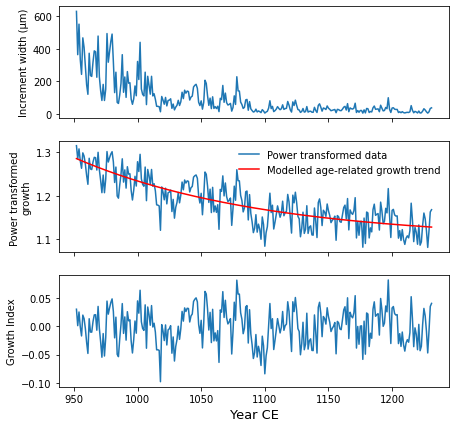

In [338]:
fig, axs = plt.subplots(3,1,figsize=(7,7),sharex=True)
ts.plot(ax=axs[0])
pow_trans.plot(ax=axs[1],label='Power transformed data')
axs[1].plot(ts.index.values, fitted_curve_pt, 'r-',label='Modelled age-related growth trend')
res_pt.plot(ax=axs[2],label='')
axs[0].set_ylabel('Increment width (μm)');
axs[1].set_ylabel('Power transformed \ngrowth');
axs[2].set_ylabel('Growth Index');
axs[2].set_xlabel('Year CE',fontsize=13);
axs[1].legend(frameon=False);

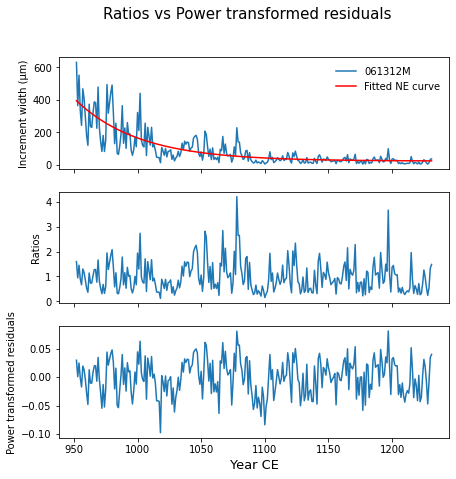

In [339]:
fig, axs = plt.subplots(3,1,figsize=(7,7),sharex=True)
ts.plot(ax=axs[0])
axs[0].plot(ts.index.values, negexp(ind, *popt_shell2), 'r-',label='Fitted NE curve')
ratios.plot(ax=axs[1])
res_pt.plot(ax=axs[2])
axs[0].set_ylabel('Increment width (μm)');
axs[1].set_ylabel('Ratios');
axs[2].set_ylabel('Power transformed residuals');
axs[2].set_xlabel('Year CE',fontsize=13);
axs[0].legend(frameon=False);
fig.suptitle('Ratios vs Power transformed residuals', fontsize=15);

<a id='references'></a>
### References
- Butler, P. G., Wanamaker, A. D., Scourse, J. D., Richardson, C. A., & Reynolds, D. J. (2013). Variability of marine climate on the North Icelandic Shelf in a 1357-year proxy archive based on growth increments in the bivalve Arctica islandica. Palaeogeography, Palaeoclimatology, Palaeoecology, 373, 141–151. https://doi.org/10.1016/j.palaeo.2012.01.016

- Cook, E. R., & Holmes, R. L. (1986). Guide for computer program ARSTAN. In Tree-Ring Chronologies of Western North America: California,eastern Oregon and northern Great Basin (pp. 50–65). Laboratory of Tree Ring Research, The University of Arizona.

- Cook, E. R., & Peters, K. (1997). Calculating unbiased tree-ring indices for the study of climatic and environmental change. The Holocene, 7(3), 361–370. https://doi.org/10.1177/095968369700700314

In [340]:
#### Significance tests
#wL = 35
#bW = 40
#n = 2000
#mca_pval = {}
#for shell, ls in mca_shells.items():
#    ts = raw_shells[shell].dropna()
#    _,_, pt = power_transf(ts+100)
#    ts = ews.Ews(pt[(pt.index>=1110)&(pt.index<=1260)])    
#    kcb_ar1 = ts.bootstrap(detrend=True, method='ar1',bW=bW, wL=wL,n=n)
#    kcb_var = ts.bootstrap(detrend=True, method='var',bW=bW, wL=wL,n=n)
#    ar1 = ts.ar1(detrend = True, bW=bW,wL=wL)
#    var = ts.var(detrend = True, bW=bW,wL=wL)
#    kv_ar1 = ews.Ews(ar1[(ar1.index>=1200)&(ar1.index<=1260)]).kendall
#    kv_var = ews.Ews(var[(var.index>=1200)&(var.index<=1260)]).kendall
#    p_ar1 = len(kcb_ar1[kcb_ar1>=kv_ar1])/len(kcb_ar1)
#    p_var = len(kcb_var[kcb_var>=kv_var])/len(kcb_var)
#    mca_pval[shell] = [kcb_ar1,kcb_var,kv_ar1,kv_var,p_ar1,p_var]

In [341]:
#### Building an ensemble model with synthetic shells with decreasing variance to assess the effect of a variable number of replicates through time
#n = 100 ## Size of the null model
#wL = 50
#bW = 40
#kv_ar1_synth_dv = []
#kv_var_synth_dv = []
#
#for i in np.arange(0,n):
#    ind_synth_ts = []
#    for shell,ls in mca_shells.items():        
#        orig_ts = raw_shells[shell].dropna()
#        _,_, pt = power_transf(orig_ts+100)
#        ts_std = (pt - pt.mean())/pt.std()
#        stdv = np.append(np.linspace(1,0.5,100),np.repeat(0.5,len(ts_std)-100))
#        decr_var = np.random.normal(ts_std.mean(),stdv,len(ts_std))
#        synth_shell = pd.Series(index=orig_ts.index,data=decr_var)
#        ind_synth_ts.append(synth_shell)
#    chron_synth = pd.concat(ind_synth_ts, axis=1, sort=False)
#    avg_chron_synth = chron_synth.apply(stats.biweight_location, axis = 1,c=9,ignore_nan=True)
#    ar1_synth = ews.Ews(avg_chron_synth).ar1(detrend=True,wL=wL,bW=bW)
#    var_synth = ews.Ews(avg_chron_synth).var(detrend=False,wL=wL)
#    kv_ar1_s = ews.Ews(ar1_synth[(ar1_synth.index>=1200)&(ar1_synth.index<=1260)]).kendall
#    kv_var_s = ews.Ews(var_synth[(var_synth.index>=1200)&(var_synth.index<=1260)]).kendall
#    kv_ar1_synth_dv.append(kv_ar1_s)
#    kv_var_synth_dv.append(kv_var_s)